#Library

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
import os
from PIL import Image, ImageOps
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

#Install Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sdir = "/content/drive/MyDrive/CK+48"

#Data Preparation


In [ ]:
import os
filepaths = []
labels = []

class_list = os.listdir(sdir)
for klass in class_list:
    classpath = os.path.join(sdir, klass)
    flist = os.listdir(classpath)
    for f in flist:
        fpath = os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(klass)

Buat DataFrame

In [ ]:
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

#EDA

Menampilkan informasi

In [ ]:
print('Jumlah total data:', len(df))
print('Distribusi kelas:')
print(df['labels'].value_counts())

Jumlah total data: 1327
Distribusi kelas:
labels
surprise    249
contempt    210
happy       207
disgust     177
fear        175
sadness     174
anger       135
Name: count, dtype: int64


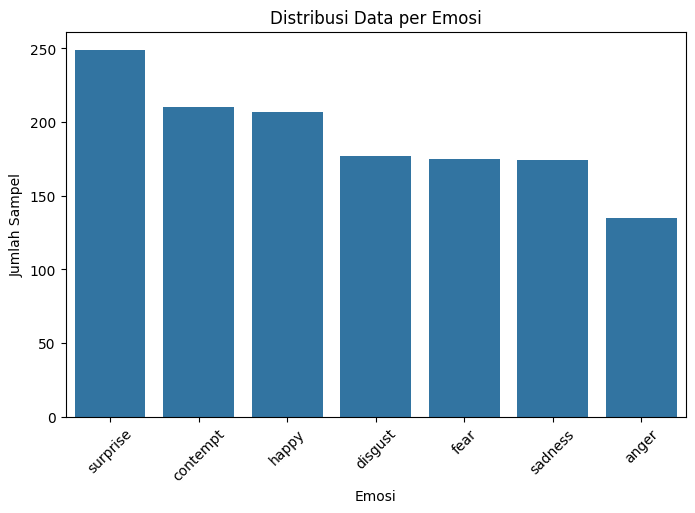

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index)
plt.title('Distribusi Data per Emosi')
plt.xlabel('Emosi')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
plt.show()

Contoh gambar per emosi

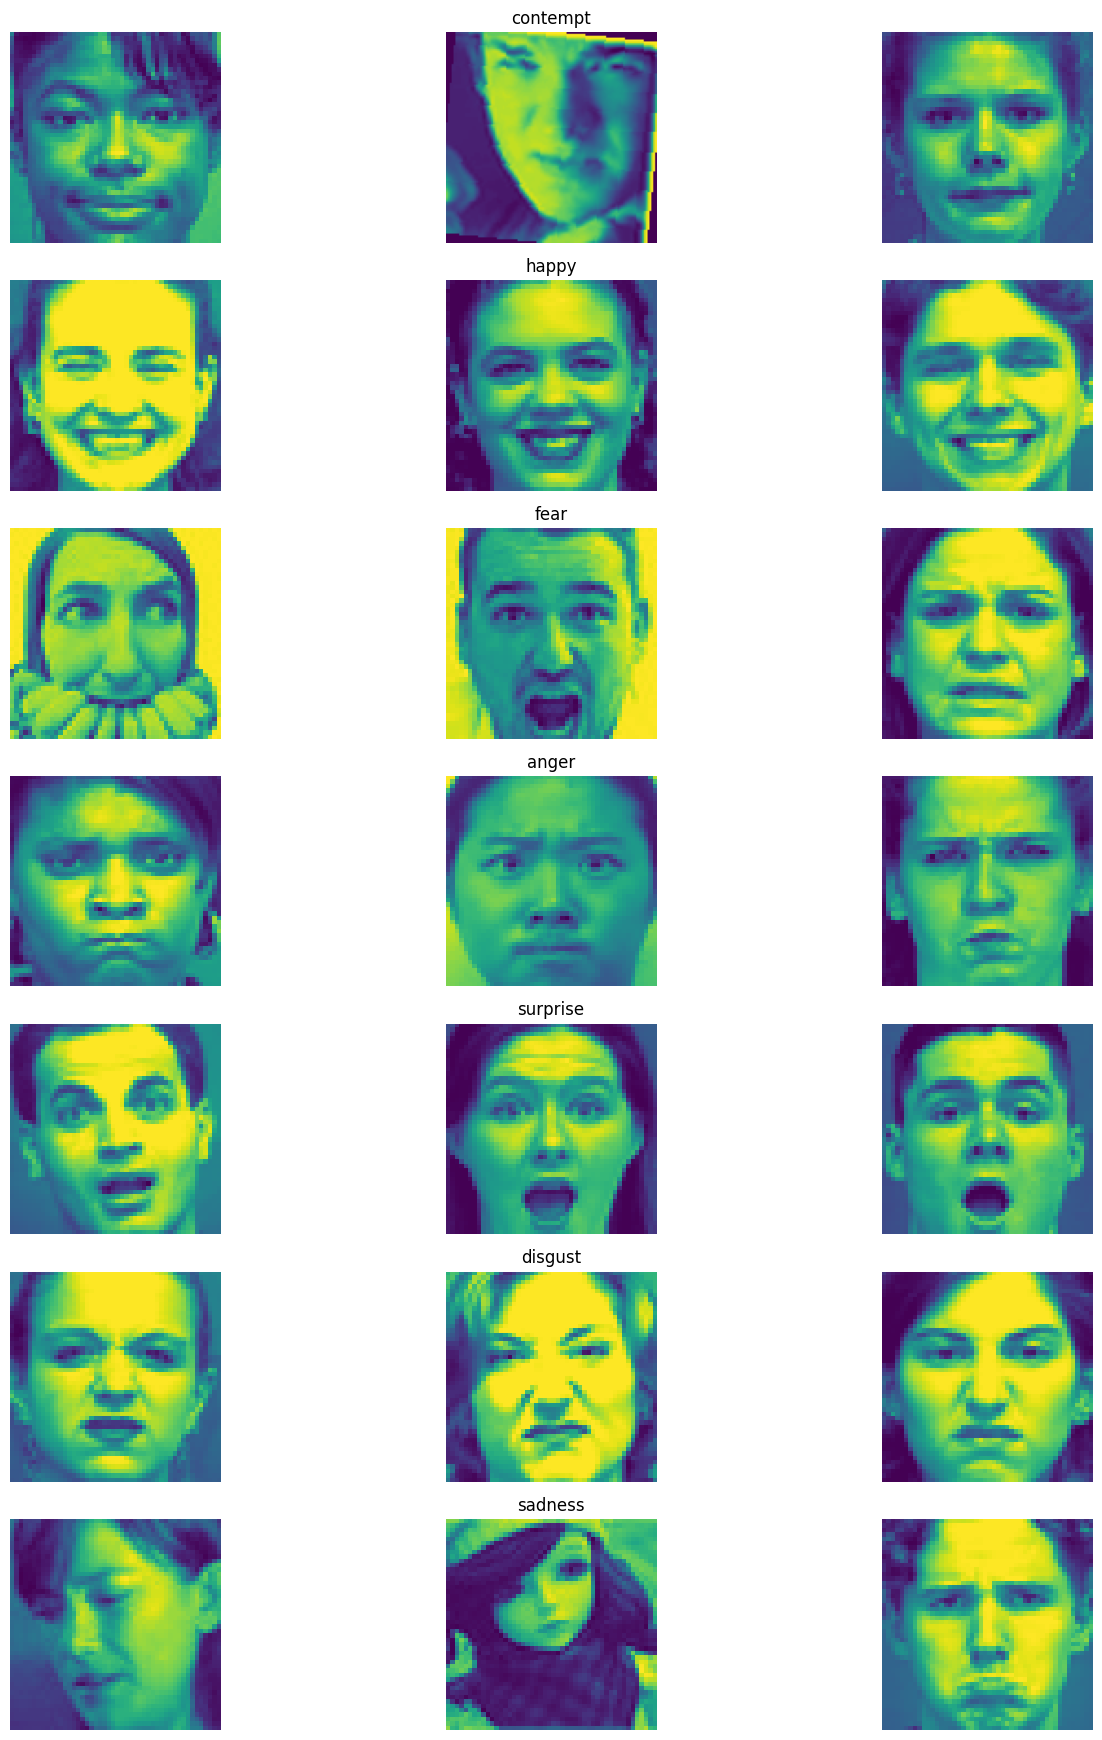

In [ ]:
def show_examples(df, num_per_class=3):
    classes = df['labels'].unique()
    plt.figure(figsize=(15, len(classes) * 2.5))

    for idx, label in enumerate(classes):
        samples = df[df['labels'] == label].sample(num_per_class, random_state=1)
        for j, path in enumerate(samples['filepaths']):
            img = mpimg.imread(path)
            plt.subplot(len(classes), num_per_class, idx * num_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 1:
                plt.title(label)

    plt.tight_layout()
    plt.show()

show_examples(df)

Cek Ukuran Gambar

In [ ]:
from collections import Counter
from PIL import Image

ukuran_gambar = []
for fpath in df['filepaths']:
    try:
        img = Image.open(fpath)
        ukuran_gambar.append(img.size)
    except Exception as e:
        print(f"Could not open image {fpath}: {e}")
print("Distribusi ukuran gambar:")
print(Counter(ukuran_gambar))

Distribusi ukuran gambar:
Counter({(48, 48): 1171, (112, 112): 156})


#Data PreProcessing

In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

Padding + Resize Gambar

In [ ]:
images_for_model = []
images_for_display = []
labels = []

for label in os.listdir(sdir):
    folder = os.path.join(sdir, label)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)

        # Convert grayscale to RGB if needed
        if img.shape[2] == 1 or len(img.shape) == 2:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        else:
            img_rgb = img # Already in BGR (or RGB)

        # Resize for model input
        img_resized_model = cv2.resize(img_rgb, IMG_SIZE)
        images_for_model.append(img_resized_model)

        # Keep original aspect ratio for display (optional, but good practice)
        # For simplicity, let's also resize for display for now
        img_resized_display = cv2.resize(img_rgb, IMG_SIZE)
        images_for_display.append(img_resized_display)

        labels.append(label)

images_for_model = np.array(images_for_model)
images_for_display = np.array(images_for_display)
labels = np.array(labels)

Label Encoder

In [ ]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
label_names = le.classes_

Split Data

In [ ]:
X_train, X_test, y_train, y_test, X_disp_train, X_disp_test = train_test_split(
    images_for_model, labels_encoded, images_for_display,
    test_size=0.2, stratify=labels_encoded, random_state=42
)

In [ ]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

Augmentasi

In [ ]:
aug = ImageDataGenerator(rotation_range=15, zoom_range=0.1, horizontal_flip=True)

X_augmented, y_augmented = [], []
count_per_class = Counter(y_train)
max_count = max(count_per_class.values())

for class_id in np.unique(y_train):
    idx = np.where(y_train == class_id)[0]
    x_class = X_train[idx]
    y_class = y_train[idx]

    if len(x_class) < max_count:
        x_class_prep = preprocess_input(x_class)
        i = 0
        for batch in aug.flow(x_class_prep, batch_size=1):
            X_augmented.append(batch[0])
            y_augmented.append(class_id)
            i += 1
            if i >= (max_count - len(x_class)):
                break

Gabungkan data

In [ ]:
X_train = preprocess_input(np.concatenate([X_train, np.array(X_augmented)]))
y_train = np.concatenate([y_train, np.array(y_augmented)])
X_test = preprocess_input(X_test)

#Penerapan Algoritma VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

Fully Connected Layer

In [ ]:
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(len(label_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Training Model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=32,
                    callbacks=[early_stop])

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step - accuracy: 0.3066 - loss: 11.3436 - val_accuracy: 0.6504 - val_loss: 1.0960
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.6278 - loss: 1.1789 - val_accuracy: 0.7744 - val_loss: 0.6968
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.7331 - loss: 0.7724 - val_accuracy: 0.8233 - val_loss: 0.5292
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.7924 - loss: 0.5883 - val_accuracy: 0.8571 - val_loss: 0.4633
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.8335 - loss: 0.4478 - val_accuracy: 0.8947 - val_loss: 0.3630
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.8766 - loss: 0.3470 - val_accuracy: 0.8947 - val_loss: 0.3360
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.9069 - loss: 0.2732 - val_accuracy: 0.8985 - val_loss: 0.3247
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.9109 - loss: 0.2605 - val_accu

#Evaluasi

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_names)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Confussion Matrix

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
Classification Report: 0.9173


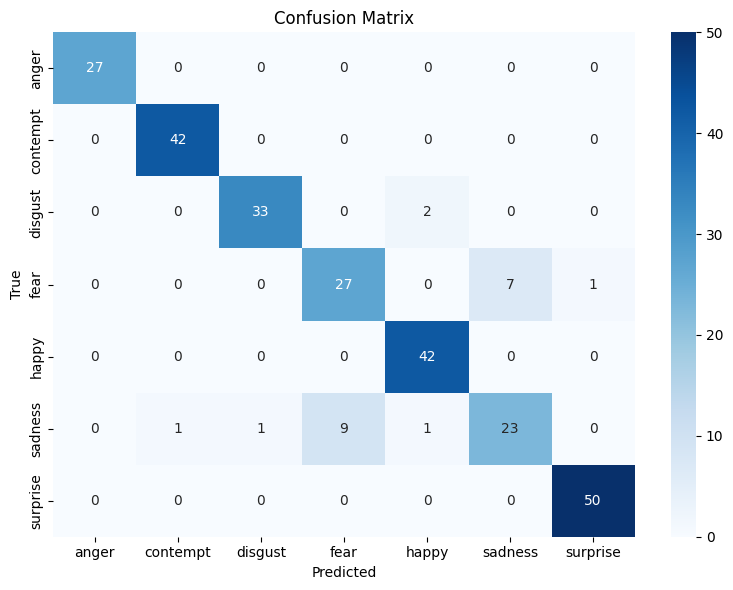

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       0.98      1.00      0.99        42
     disgust       0.97      0.94      0.96        35
        fear       0.75      0.77      0.76        35
       happy       0.93      1.00      0.97        42
     sadness       0.77      0.66      0.71        35
    surprise       0.98      1.00      0.99        50

    accuracy                           0.92       266
   macro avg       0.91      0.91      0.91       266
weighted avg       0.91      0.92      0.92       266



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi label
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Classification Report: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Print Report
print(report)

with open("classification_report.txt", "w") as f:
    f.write(f"Classification Report: {acc:.4f}\n\n")
    f.write(report)

Plot Akurasi dan Loss

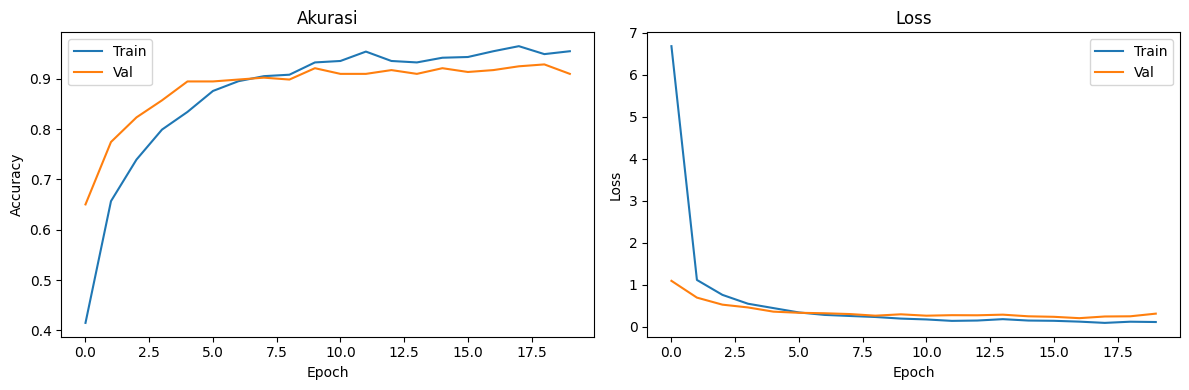

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Simpan Model dan Encoder

In [ ]:
model.save('face_emotion_vgg16.h5')
np.save('label_classes.npy', label_names)

#Prediksi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


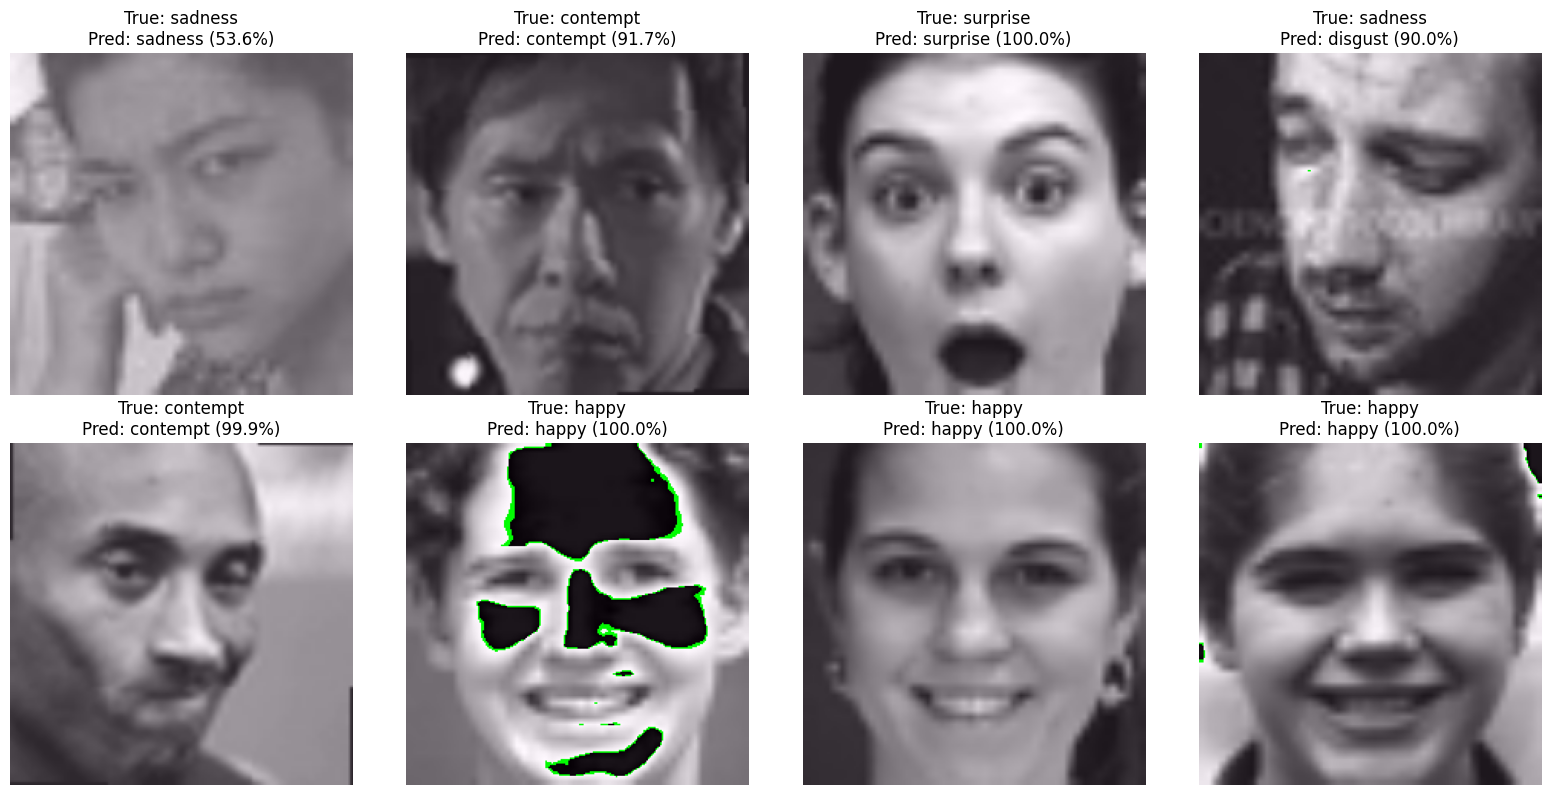

In [ ]:
# Ambil sample dari X_test dan y_test (asli, belum dipreprocess)
sample_idx = np.random.choice(len(X_test), size=8, replace=False)
raw_images = X_test[sample_idx]           # ini untuk ditampilkan (tanpa preprocess)
input_images = preprocess_input(raw_images.copy())  # ini untuk prediksi (dengan preprocess)
true_labels = y_test[sample_idx]

# Prediksi
pred_probs = model.predict(input_images)
pred_labels = np.argmax(pred_probs, axis=1)

# Konversi label
true_names = [label_names[i] for i in true_labels]
pred_names = [label_names[i] for i in pred_labels]

# Visualisasi
plt.figure(figsize=(16, 8))

for i in range(8):
    plt.subplot(2, 4, i+1)

    confidence = np.max(pred_probs[i]) * 100
    pred_text = f"{pred_names[i]} ({confidence:.1f}%)"

    # Tampilkan dengan benar
    if raw_images[i].shape[-1] == 1:
        plt.imshow(raw_images[i].squeeze(), cmap='gray')  # grayscale
    else:
        img_rgb = np.clip(raw_images[i].astype(np.uint8), 0, 255)
        plt.imshow(img_rgb)

    plt.title(f"True: {true_names[i]}\nPred: {pred_text}")
    plt.axis('off')

plt.tight_layout()
plt.show()